# Context

There are some situations when for some reason plotting waterfall plots (which are the most useful ones to understand SHAP outputs) is complicated. SHAP's implementation of the `waterfall` function has changed over time, and we have personally experienced situations when:
* You need to "hack" the SHAP attributes to account for multi-outputs
* You need to create some container class with all useful attributes

We do both below.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

import shap
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# Setup

This is done for SHAP version 0.37.0

In [66]:
shap.__version__

'0.37.0'

Data from https://archive.ics.uci.edu/ml/datasets/banknote+authentication, a small classification problem:

In [2]:
df = pd.read_csv('data_banknote_authentication.txt', header=None)
df.columns = ['var', 'skew', 'kurt', 'entr', 'class']
X = df[['var', 'skew', 'kurt', 'entr']]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

## Make SHAP classification values appear for a random forest

In [83]:
model = RandomForestClassifier(random_state=12).fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:,1]
print("ROC AUC :", round(roc_auc_score(y_test, y_probs),3))
print("Avg Prec:", round(average_precision_score(y_test, y_probs),3))

ROC AUC : 1.0
Avg Prec: 1.0


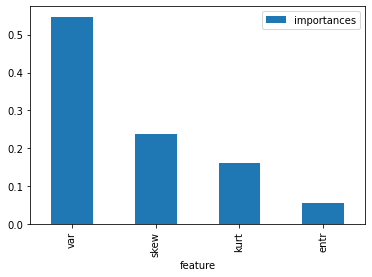

In [69]:
imps = pd.DataFrame({'feature': X.columns, 
              'importances': model.feature_importances_}
            ).sort_values('importances', ascending=False)

imps.plot.bar(x='feature', y='importances')
plt.show()

### SHAP - for RandomForest, we need a hack!

In [86]:
explainer = shap.TreeExplainer(model, X_train, model_output='probability')
shap_values = explainer(X_test)

# hacking to make outputs easier for SHAP
shap_values.values = shap_values.values[:,:,1]
shap_values.base_values = shap_values.base_values[:,1]

#### Beeswarm

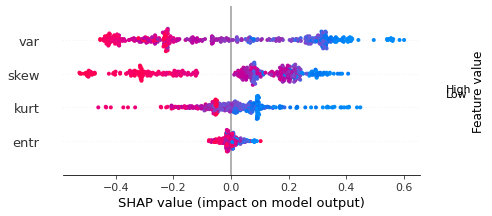

In [87]:
shap.plots.beeswarm(shap_values)

## Waterfall plots - the main ones I'm interested in

In [73]:
from dataclasses import dataclass

@dataclass
class ShapObject:
    base_values: float
    data: np.array
    values: np.array
    feature_names: list

In [74]:
i = 32

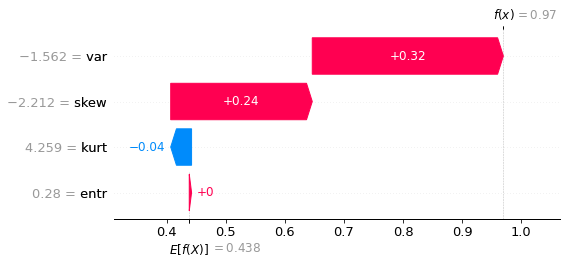

In [75]:
shap_object = ShapObject(base_values=shap_values.base_values[0],
                         data=X_test.iloc[i].values,
                         values=shap_values.values[i],
                         feature_names=X.columns.tolist())

shap.plots.waterfall(shap_object)

# For LightGBM - also working just fine

In [76]:
model = lgb.LGBMClassifier().fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:,1]
print("ROC AUC :", round(roc_auc_score(y_test, y_probs),3))
print("Avg Prec:", round(average_precision_score(y_test, y_probs),3))

ROC AUC : 1.0
Avg Prec: 1.0


In [78]:
explainer = shap.TreeExplainer(model, X_train, model_output='probability')
shap_values = explainer(X_test)

# hacking not necessary!

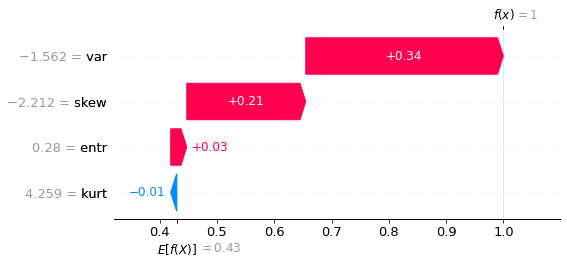

In [79]:
shap_object = ShapObject(base_values=shap_values.base_values[0],
                         data=X_test.iloc[i].values,
                         values=shap_values.values[i],
                         feature_names=X.columns.tolist())

shap.plots.waterfall(shap_object)

# For XGBoost 

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[23:37:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC AUC : 1.0
Avg Prec: 1.0


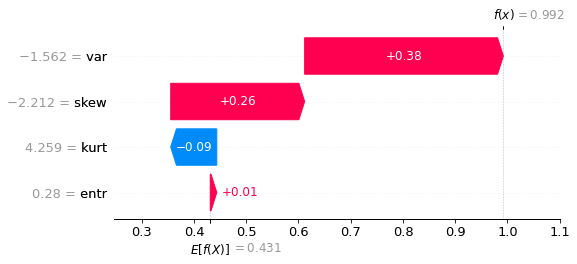

In [80]:
model = xgb.XGBClassifier(use_label_encoder=False).fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:,1]
print("ROC AUC :", round(roc_auc_score(y_test, y_probs),3))
print("Avg Prec:", round(average_precision_score(y_test, y_probs),3))

explainer = shap.TreeExplainer(model, X_train, model_output='probability')
shap_values = explainer(X_test)

shap_object = ShapObject(base_values=shap_values.base_values[0],
                         data=X_test.iloc[i].values,
                         values=shap_values.values[i],
                         feature_names=X.columns.tolist())

shap.plots.waterfall(shap_object)

# HistGBC also doesn't need hacking

In [81]:
from sklearn.ensemble import HistGradientBoostingClassifier

ROC AUC : 1.0
Avg Prec: 1.0


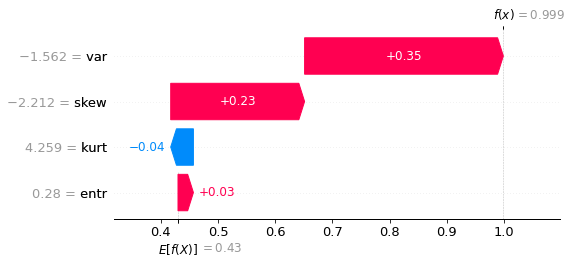

In [82]:
model = HistGradientBoostingClassifier(random_state=3).fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:,1]
print("ROC AUC :", round(roc_auc_score(y_test, y_probs),3))
print("Avg Prec:", round(average_precision_score(y_test, y_probs),3))

explainer = shap.TreeExplainer(model, X_train, model_output='probability')
shap_values = explainer(X_test)


shap_object = ShapObject(base_values=shap_values.base_values[0],
                         data=X_test.iloc[i].values,
                         values=shap_values.values[i],
                         feature_names=X.columns.tolist())

shap.plots.waterfall(shap_object)

# Old stuff

In [22]:
## without hacking the output
# shap_object = ShapObject(base_values=shap_values.base_values[0][1],
#                          data=X_test.iloc[i].values,
#                          values=shap_values.values[:,:,1][i],
#                          feature_names=X.columns.tolist())

# shap.plots.waterfall(shap_object)

### Alternative way to plot, without hacking anything
# fig, ax = plt.subplots()
# shap.plots._waterfall.waterfall_legacy(expected_value=shap_values.base_values[0][1], 
#                                        shap_values=shap_values.values[:,:,1][i],
#                                        features=X_test.iloc[i].values,
#                                        feature_names=X.columns.tolist(),
#                                        show=False)
# plt.xlabel("Lol")
# plt.show()